#### LangChain vs LangGraph (feat. LangGraph 개념 설명)
* LangGraph의 개념과 주요 기능을 이해하고, 차이점을 비교합니다.

In [6]:
# poetry add langgraph

In [7]:
#!pip install langgraph

In [8]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
24


In [9]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model='gpt-4o-mini') # 테스트의 경우에는 작은 모델을 사용합니다

from langchain_upstage import ChatUpstage
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
    )
print(llm)

query = 'LangGraph는 무엇인가요?'
ai_msg = llm.invoke(query)
print(ai_msg.content)

client=<openai.resources.chat.completions.completions.Completions object at 0x11662e990> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x11662f390> model_name='solar-pro' temperature=0.5 model_kwargs={} upstage_api_key=SecretStr('**********') upstage_api_base='https://api.upstage.ai/v1'
**LangGraph**는 **LangChain** 생태계에서 제공하는 **상태(state) 관리가 가능한 그래프 기반 프레임워크**로, 복잡한 LLM(Large Language Model) 애플리케이션의 흐름을 구조화하고 관리할 수 있도록 설계되었습니다.  

### 📌 **LangGraph의 핵심 개념**
1. **그래프 기반 워크플로우**  
   - 노드(Node)와 엣지(Edge)로 구성된 방향성 그래프로, LLM 체인을 시각화/관리합니다.  
   - 예: `Chain A → Router → Chain B/C`와 같은 분기 구조 구현 가능.

2. **상태(State) 관리**  
   - 각 노드 간 전달되는 데이터(`state`)를 자동으로 추적하며, 메모리/데이터베이스와 연동해 장기 상태를 유지할 수 있습니다.  
   - 예: 대화 기록, 사용자 프로필 등을 그래프 내에서 유지.

3. **확장성**  
   - LangChain의 기존 컴포넌트(Chains, Tools, Agents)와 호환되며, 복잡한 애플리케이션을 모듈식으로 구축 가능.

4. **실시간 협업 지원**  
   - 여러 사용자 세션이나 병렬 처리를 위한 상태 분리 기능을 제공합니다.

---

### 🛠 **주요 사용 사례**
- **대화형 에이전트**: 멀티턴 대화 관리, 상태 기반 응답 생

#### LangGraph의 기본개념
* `state`는 LangGraph 에이전트의 state를 나타내는 데이터 구조입니다.
* `state`는 `TypedDict`를 사용하여 정의되며, 이는 Python의 타입 힌팅을 통해 구조를 명확히 합니다.
    * 간단하게 `messages`라는 필드만 있습니다.
    * 필요에 따라 다양한 값들을 활용할 수 있습니다.
* `state`는 에이전트의 동작을 결정하는 데 사용되며, 각 노드에서 state를 업데이트하거나 참조할 수 있습니다.
* `state`는 LangGraph의 노드 간에 전달되며, 에이전트의 state 전이를 관리합니다.

In [10]:
from typing import Annotated # 타입 힌트를 사용하기 위해 
from typing_extensions import TypedDict # 구조화된 딕셔너리 타입을 정의하기 위해 

from langgraph.graph.message import add_messages 
from langchain_core.messages import AnyMessage # LangChain에서 사용하는 모든 종류의 메시지(예: HumanMessage, AIMessage, ToolMessage)

# AgentState는 에이전트의 현재 상태를 나타내는 딕셔너리 타입을 정의합니다.
# TypedDict를 사용하면 딕셔너리가 어떤 키와 값 타입을 가져야 하는지 명확하게 지정할 수 있습니다.
class AgentState(TypedDict):
    # 'messages' 키는 에이전트의 대화 기록을 저장합니다.
    # 이 목록에는 LangChain 메시지 객체(AnyMessage)가 들어갑니다.
    # LangGraph가 이 상태를 처리할 때, 새로운 메시지가 추가되면
    # 기존 메시지 목록의 끝에 자동으로 추가되도록(append) 설정합니다.
    messages: list[Annotated[AnyMessage, add_messages]]

- 위에 선언한 `AgentState`를 활용하여 `StateGraph`를 생성합니다.

In [11]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)
print(type(graph_builder))

<class 'langgraph.graph.state.StateGraph'>


- `graph`에 추가할 `node`를 생성합니다
-  `node`는 LangGraph에서 실행되는 개별적인 작업 단위를 의미합니다. 
    - 각 노드는 특정 기능을 수행하는 독립적인 컴포넌트로, 예를 들어 텍스트 생성, 데이터 처리, 또는 의사 결정과 같은 작업을 담당할 수 있습니다.
    - `node`는 기본적으로 함수(function)로 정의되고, 뒤에서 다루지만 다른 에이전트(agent)를 활용할 수도 있습니다

In [12]:
# Node 역할을 하는 함수의 인자로 state 객체를 사용함  LLM을 호출하는 노드
def generate(state: AgentState) -> AgentState:
    """
    `generate` 노드는 사용자의 질문을 받아서 응답을 생성하는 노드입니다.
    """
    messages = state['messages']
    ai_message = llm.invoke(messages)
    return {'messages': [ai_message]}

- `node`를 생성한 후에 `edge`로 연결합니다
- `edge`는 노드들 사이의 연결을 나타내며, 데이터와 제어 흐름의 경로를 정의합니다. 
    - 엣지를 통해 한 노드의 출력이 다음 노드의 입력으로 전달되어, 전체적인 워크플로우가 형성됩니다.
    - `node`와 `edge`의 조합은 방향성 그래프(Directed Graph)를 형성하며, 이를 통해 복잡한 AI 에이전트의 행동 흐름을 구조화할 수 있습니다

In [13]:
# LLM을 호출하는 generate 함수를 Node로 추가함
graph_builder.add_node('generate', generate)

- 모든 그래프는 `START(시작)`와 `END(종료)`가 있습니다
    - `END`를 explicit하게 선언하지 않는 경우도 종종 있지만, 가독성을 위해 작성해주는 것을 권장합니다

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)

- `node`를 생성하고 `edge`로 연결한 후에 `compile` 메서드를 호출하여 `Graph`를 생성합니다

In [15]:
graph = graph_builder.compile()
print(type(graph))

<class 'langgraph.graph.state.CompiledStateGraph'>


- `compile` 후에는 그래프를 시각화하여 확인할 수 있습니다
- 의도한대로 그래프가 생성됐는지 확인하는 습관을 기르는 것이 좋습니다
    - `git`에서 코드 작업물을 commit하기 전에 `git diff`를 통해 변경사항을 확인하는 것과 같습니다

In [16]:
#from IPython.display import display, Image

#display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [17]:
# 대체 방법
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	generate(generate)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate;
	generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph 이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNpVkN1ugjAUx1-lObvRBLCAVq3Gm_kIu9q6mAqn0AwKKSWZM777KirR3vR8_f7n4wxZkyNwKKxsS_Kx3wgj3OHQOWn9N_natrvR287a3feUc6607dy1sECDVjqcPIzpDUeTj_Bgj2glb-QoSsJwRx745ll0yNz5IZF5uNujIjkq2VeOKF1V_E0liioVVNpgWKIuSsfjKHkBhoGH8rBpZabdidOXgutYd7mjOjKVQeBPonPgzvYYQI22llcXzsIQIsCVWKMA7s1c2h8Bwlw800rz2TT1A7NNX5TAlaw67_Vt7tfaa-mPXY9R6xdE-970xgFP4kED-Bl-gaeURYyyNEmXbJGuaDIP4OTDLIqT-XoVp2tK54ytLwH8DV1ptFou6NOLL_-94J8W) 

In [18]:
from langchain_core.messages import HumanMessage

query = 'LangGraph는 무엇인가요? LangChain과의 차이점은 무엇인가요?'
initial_state = {'messages': [HumanMessage(query)]}
result = graph.invoke(initial_state)

print(type(result))
print(type(result['messages'][0]))
print(result['messages'])

<class 'dict'>
<class 'langchain_core.messages.ai.AIMessage'>
[AIMessage(content='**LangGraph**와 **LangChain**은 모두 LLM(Large Language Model) 기반 애플리케이션 개발을 위한 프레임워크이지만, 목적과 적용 범위에서 차이가 있습니다. 아래에 각 도구의 특징과 차이점을 정리했습니다.\n\n---\n\n### **1. LangChain이란?**\n- **정의**: LangChain은 LLM을 활용해 복잡한 애플리케이션을 구축할 수 있도록 돕는 **모듈형 프레임워크**입니다.\n- **주요 기능**:\n  - **모듈 조합**: 프롬프트 관리, 체인(Chain), 메모리, 검색(Retrieval), 에이전트(Agent) 등 다양한 컴포넌트를 조합해 유연한 파이프라인 구성 가능.\n  - **다양한 LLM 지원**: OpenAI, Anthropic, Llama 등 다양한 모델과 호환.\n  - **유스 케이스**: 챗봇, 문서 분석, 요약, QA 시스템 등 **단일 또는 순차적 작업**에 최적화.\n- **예시**:  \n  ```python\n  from langchain.chains import LLMChain\n  from langchain.prompts import PromptTemplate\n  from langchain.llms import OpenAI\n\n  llm = OpenAI(model_name="gpt-3.5-turbo")\n  prompt = PromptTemplate(input_variables=["topic"], template="설명해 주세요: {topic}")\n  chain = LLMChain(llm=llm, prompt=prompt)\n  chain.run("기후 변화")\n  ```\n\n---\n\n### **2. LangGraph란?**\n- **정의**: LangGraph는 **상태(State)가 있는 복잡한 워크플로우**

#### 2개의 AI 에이전트 협력하기
* 첫번째 AI 에이전트
    * 사용자의 질문을 분석하고 핵심 키워드와 배경 정보를 추가하는 역할
* 두번째 AI 에이전트
    * 첫번째 에이전트가 제공한 정보를 기반으로 좀 더 자세한 답변을 생성하는 역할    

In [19]:
print(llm.model_name)

solar-pro


In [20]:
from langgraph.graph import StateGraph
from pprint import pprint

#첫번째 AI 에이전트
def agent_1(state):
    """사용자의 질문을 분석하고 핵심 키워드아 배경 정보를 추가하는 역할"""
    query = state['query']
    
    keywords = llm.invoke(f'질문: {query}\n 이 질문에서 핵심 키워드를 3~5개 추출해 주세요.')

     # 질문과 관련된 배경 정보 제공
    background_info = llm.invoke(f"질문: {query}\n 이 질문을 이해하는 데 도움이 될 만한 추가 정보를 제공해 주세요.")

    print(f"\n[Agent 1] 원본 질문: {query}")
    print(f"[Agent 1] 핵심 키워드: {keywords}")
    print(f"[Agent 1] 배경 정보: {background_info}\n")

    return {"refined_query": query, "keywords": keywords, "background_info": background_info}

In [21]:
# 두번째 AI 에이전트
def agent_2(state):
    """첫번째 에이전트가 제공한 정보를 기반으로 좀 더 자세한 답변을 생성하는 역할"""
    refined_query = state['refined_query']
    keywords = state['keywords']
    background_info = state['background_info']

    # Agent 1이 제공한 정보를 활용하여 최종 답변 생성
    final_response = llm.invoke(
        f"질문: {refined_query}\n"
        f"핵심 키워드: {keywords}\n"
        f"배경 정보: {background_info}\n"
        f"위 정보를 바탕으로 질문에 대한 깊이 있는 답변을 작성해 주세요."
    )

    print(f"[Agent 2] 최종 답변 생성 완료\n")
    
    return {"final_answer": final_response}

In [22]:
# WorkFlow 역할을 하는 StateGraph 객체를 생성하기
workflow = StateGraph(dict)

print(type(workflow))
print(workflow.schemas)

<class 'langgraph.graph.state.StateGraph'>
{<class 'dict'>: {'__root__': <langgraph.channels.last_value.LastValue object at 0x1166689c0>}}


In [23]:
# WorkFlow에 Node 추가하기
workflow.add_node("agent_1", agent_1)
workflow.add_node("agent_2", agent_2)

workflow.nodes

{'agent_1': StateNodeSpec(runnable=agent_1(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'agent_2': StateNodeSpec(runnable=agent_2(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

In [24]:
# WorkFlow에 Edge 추가하기
# agent_1이 먼저 실행됨
workflow.set_entry_point("agent_1")
# agent_1 -> agent_2
workflow.add_edge("agent_1","agent_2")

print(workflow.edges)

{('agent_1', 'agent_2'), ('__start__', 'agent_1')}


<class 'langgraph.graph.state.CompiledStateGraph'>


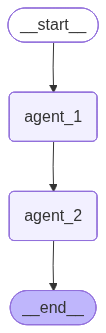

In [25]:
graph = workflow.compile()

print(type(graph))
graph

In [26]:
mermaid_code = graph.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent_1(agent_1)
	agent_2(agent_2)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent_1;
	agent_1 --> agent_2;
	agent_2 --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [27]:
# Graph 호출하기
query = "LangGraph는 무엇이며, LangChain과 어떤 차이점이 있나요? 그리고 LangGraph를 사용해야 하는 이유는 무엇인가요?"

state = {"query": query}
result = graph.invoke(state)
print(result)


[Agent 1] 원본 질문: LangGraph는 무엇이며, LangChain과 어떤 차이점이 있나요? 그리고 LangGraph를 사용해야 하는 이유는 무엇인가요?
[Agent 1] 핵심 키워드: content='핵심 키워드:  \n1. **LangGraph**  \n2. **LangChain**  \n3. **차이점**  \n4. **사용 이유**  \n\n(추가로 "워크플로우 관리"나 "상태 기반 추론"을 포함할 수도 있지만, 질문의 핵심 요구사항을 고려해 4개로 압축했습니다.)' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 49, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': '3b9fec8c-c7cf-4818-a70b-bc14f1c2650e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--bfbe0731-f5e7-4113-ad2d-987b7f82e18d-0' usage_metadata={'input_tokens': 49, 'output_tokens': 61, 'total_tokens': 110, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'

In [28]:
print(result)

{'final_answer': AIMessage(content='### **LangGraph와 LangChain의 차이점 및 LangGraph 사용 이유**\n\n#### 1. **LangGraph란?**  \nLangGraph는 **상태(State) 기반의 복잡한 워크플로우**를 구축하기 위한 프레임워크로, LangChain의 확장 도구입니다.  \n- **핵심 기능**:  \n  - **상태 관리**: 대화 기록, 외부 데이터, 사용자 입력 등을 JSON/딕셔너리 형태로 추적합니다.  \n  - **그래프 기반 구조**: 노드(LLM 호출, 툴킷, 조건 분기)와 엣지(상태 전이)로 구성된 유한 상태 머신(FSM)을 정의합니다.  \n  - **시각적 디버깅**: 워크플로우를 그래프 형태로 시각화하여 복잡한 로직을 명확히 이해할 수 있습니다.  \n\n#### 2. **LangChain vs. LangGraph: 주요 차이점**  \n| **기준**       | **LangChain**                          | **LangGraph**                          |\n|----------------|----------------------------------------|----------------------------------------|\n| **목적**       | 단순/단일 LLM 작업 (Q&A, 요약)         | 다단계 상태 기반 애플리케이션 (대화형 에이전트, 태스크 자동화) |\n| **구조**       | 선형 체이닝, 에이전트, 메모리           | 상태 그래프 (노드 + 엣지)              |\n| **상태 관리**  | 제한적 (메모리 모듈로 부분적 지원)      | 명시적 상태 추적 (JSON 기반)           |\n| **유연성**     | 빠른 프로토타이핑에 적합               | 분기/루프/조건 로직에 최적화           |\n| 

In [29]:

pprint(result['final_answer'].content)

('### **LangGraph와 LangChain의 차이점 및 LangGraph 사용 이유**\n'
 '\n'
 '#### 1. **LangGraph란?**  \n'
 'LangGraph는 **상태(State) 기반의 복잡한 워크플로우**를 구축하기 위한 프레임워크로, LangChain의 확장 '
 '도구입니다.  \n'
 '- **핵심 기능**:  \n'
 '  - **상태 관리**: 대화 기록, 외부 데이터, 사용자 입력 등을 JSON/딕셔너리 형태로 추적합니다.  \n'
 '  - **그래프 기반 구조**: 노드(LLM 호출, 툴킷, 조건 분기)와 엣지(상태 전이)로 구성된 유한 상태 머신(FSM)을 '
 '정의합니다.  \n'
 '  - **시각적 디버깅**: 워크플로우를 그래프 형태로 시각화하여 복잡한 로직을 명확히 이해할 수 있습니다.  \n'
 '\n'
 '#### 2. **LangChain vs. LangGraph: 주요 차이점**  \n'
 '| **기준**       | **LangChain**                          | '
 '**LangGraph**                          |\n'
 '|----------------|----------------------------------------|----------------------------------------|\n'
 '| **목적**       | 단순/단일 LLM 작업 (Q&A, 요약)         | 다단계 상태 기반 애플리케이션 (대화형 '
 '에이전트, 태스크 자동화) |\n'
 '| **구조**       | 선형 체이닝, 에이전트, 메모리           | 상태 그래프 (노드 + 엣지)              '
 '|\n'
 '| **상태 관리**  | 제한적 (메모리 모듈로 부분적 지원)      | 명시적 상태 추적 (JSON 기반)           |\n'
 '| **유연성**     | 빠른 프로토타이핑에 적합   